# 深度卷积神经网络（AlexNet）
:label:`sec_alexnet`


尽管在LeNet :cite:`LeCun.Jackel.Bottou.ea.1995`引入之后，CNN在计算机视觉和机器学习社区中广为人知，但它们并没有立即主导该领域。虽然LeNet在早期的小型数据集上取得了良好的结果，但在更大、更现实的数据集上训练CNN的性能和可行性尚未得到证实。事实上，在20世纪90年代初至2012年具有里程碑意义的结果 :cite:`Krizhevsky.Sutskever.Hinton.2012`之间的大部分时间里，神经网络往往被其他机器学习方法超越，例如核方法 :cite:`Scholkopf.Smola.2002`、集成方法 :cite:`Freund.Schapire.ea.1996`和结构化估计 :cite:`Taskar.Guestrin.Koller.2004`。

对于计算机视觉而言，这种比较或许并不完全准确。也就是说，尽管卷积网络的输入由原始或轻度处理过的（例如通过中心化）像素值组成，但实践者永远不会将原始像素直接输入到传统模型中。相反，典型的计算机视觉流水线包括手动设计特征提取流水线，如SIFT :cite:`Lowe.2004`、SURF :cite:`Bay.Tuytelaars.Van-Gool.2006`和词袋模型 :cite:`Sivic.Zisserman.2003`。与其说是*学习*特征，不如说是*精心设计*了特征。大部分进展来自于一方面有更多巧妙的特征提取想法，另一方面对几何学的深刻理解 :cite:`Hartley.Zisserman.2000`。学习算法常常被视为事后的考虑。

尽管在20世纪90年代已经有一些神经网络加速器可用，但它们还不足以支持具有大量参数的深度多通道、多层CNN。例如，1999年的NVIDIA GeForce 256最多只能处理每秒480百万次浮点运算（MFLOPS），而且没有任何有意义的操作编程框架超出游戏范围。今天的加速器能够在每个设备上执行超过1000 TFLOPs。此外，数据集仍然相对较小：在60,000张低分辨率$28 \times 28$像素图像上的OCR被认为是一项极具挑战性的任务。除此之外，训练神经网络的关键技巧，包括参数初始化启发式方法 :cite:`Glorot.Bengio.2010`、随机梯度下降的聪明变体 :cite:`Kingma.Ba.2014`、非压缩激活函数 :cite:`Nair.Hinton.2010`以及有效的正则化技术 :cite:`Srivastava.Hinton.Krizhevsky.ea.2014`仍然缺失。

因此，与其训练*端到端*（从像素到分类）系统，传统的流水线看起来更像是这样：

1. 获取一个有趣的数据集。在早期，这些数据集需要昂贵的传感器。例如，1994年的[Apple QuickTake 100](https://en.wikipedia.org/wiki/Apple_QuickTake)拥有惊人的0.3兆像素（VGA）分辨率，能够存储多达8张图片，所有这一切的价格为1000美元。
1. 基于光学、几何学和其他分析工具的知识，偶尔还有幸运研究生的偶然发现，使用手工设计的特征预处理数据集。
1. 将数据通过一组标准特征提取器，如SIFT（尺度不变特征变换） :cite:`Lowe.2004`、SURF（加速鲁棒特征） :cite:`Bay.Tuytelaars.Van-Gool.2006`或任何数量的手调流水线。OpenCV至今仍提供SIFT提取器！
1. 将生成的表示放入你最喜欢的分类器中，可能是线性模型或核方法，以训练分类器。

如果你与机器学习研究人员交谈，他们会回答说机器学习既重要又美丽。优雅的理论证明了各种分类器的性质 :cite:`boucheron2005theory`，而凸优化 :cite:`Boyd.Vandenberghe.2004`已成为获得它们的主要手段。机器学习领域正在蓬勃发展，严谨且极为有用。然而，如果你与计算机视觉研究人员交谈，你会听到一个非常不同的故事。他们会告诉你，图像识别的不光彩真相是，特征、几何 :cite:`Hartley.Zisserman.2000,hartley2009global`和工程，而不是新的学习算法，推动了进步。计算机视觉研究人员认为，稍微大一些或更干净的数据集，或者稍微改进的特征提取流水线，比任何学习算法都更能影响最终的准确性。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 表征学习

另一种描述现状的方式是，管道中最重要的部分是表征。直到2012年，表征主要是通过机械方式计算的。实际上，设计一组新的特征函数、改进结果和撰写方法在论文中都占有重要地位。SIFT :cite:`Lowe.2004`、SURF :cite:`Bay.Tuytelaars.Van-Gool.2006`、HOG（方向梯度直方图）:cite:`Dalal.Triggs.2005`、视觉词汇袋 :cite:`Sivic.Zisserman.2003` 和类似的特征提取器占据了主导地位。

另一组研究人员，包括Yann LeCun、Geoff Hinton、Yoshua Bengio、Andrew Ng、Shun-ichi Amari和Juergen Schmidhuber，有不同的计划。他们认为特征本身应该是可学习的。此外，他们认为为了具有合理的复杂性，特征应该分层组合，由多个共同学习的层组成，每层都有可学习的参数。对于图像而言，最低层可能会检测边缘、颜色和纹理，类似于动物视觉系统处理输入的方式。特别是，自动设计如稀疏编码 :cite:`olshausen1996emergence` 所获得的视觉特征仍然是一个未解决的挑战，直到现代CNN的出现。直到 :citet:`Dean.Corrado.Monga.ea.2012,le2013building` 时，从图像数据自动生成特征的想法才获得了显著的关注。

第一个现代CNN :cite:`Krizhevsky.Sutskever.Hinton.2012`，以其中一位发明者Alex Krizhevsky的名字命名为*AlexNet*，主要是在LeNet基础上的进化改进。它在2012年的ImageNet挑战赛中取得了优异的表现。

![由AlexNet第一层学习到的图像滤波器。图片来自 :citet:`Krizhevsky.Sutskever.Hinton.2012`.](../img/filters.png)
:width:`400px`
:label:`fig_filters`

有趣的是，在网络的最底层，模型学到了一些类似于传统滤波器的特征提取器。:numref:`fig_filters` 显示了低级图像描述符。网络中的更高层可能基于这些表示来表示更大的结构，比如眼睛、鼻子、草叶等。甚至更高的层可能代表整个对象，如人、飞机、狗或飞盘。最终，最后一个隐藏状态学习到了一个紧凑的图像表示，能够总结其内容，使得属于不同类别的数据可以容易地区分开来。

AlexNet (2012) 和它的前身 LeNet (1995) 共享许多架构元素。这就提出了一个问题：为什么花了这么长时间？关键的区别在于，在过去的二十年里，可用的数据量和计算能力大幅增加。因此，AlexNet要大得多：它在更多的数据上进行训练，并且使用了比1995年可用的CPU快得多的GPU。

### 缺失的要素：数据

多层深度模型需要大量数据才能进入显著优于基于凸优化的传统方法（例如线性和核方法）的阶段。然而，由于计算机存储容量有限、(成像)传感器相对昂贵以及1990年代研究预算较为紧张，大多数研究依赖于小型数据集。许多论文依赖于UCI数据集集合，其中许多数据集仅包含数百或数千张分辨率较低且通常背景人为干净的图像。

2009年发布的ImageNet数据集 :cite:`Deng.Dong.Socher.ea.2009` 挑战研究人员从100万个示例中学习模型，每个示例来自1000个不同的对象类别。这些类别基于WordNet中最受欢迎的名词节点 :cite:`Miller.1995`。ImageNet团队使用Google Image Search预先筛选每个类别的大型候选集，并利用Amazon Mechanical Turk众包流程确认每张图像是否属于相关类别。这种规模前所未有，超过了其他数据集一个数量级以上（例如，CIFAR-100有60,000张图像）。另一个方面是图像分辨率为$224 \times 224$像素，而80百万大小的TinyImages数据集 :cite:`Torralba.Fergus.Freeman.2008` 的图像为$32 \times 32$像素缩略图。这允许形成更高级别的特征。相关的竞赛被称为ImageNet大规模视觉识别挑战赛 :cite:`russakovsky2015imagenet`，推动了计算机视觉和机器学习研究的发展，挑战研究人员确定哪些模型在比学术界之前考虑的更大规模上表现最佳。最大的视觉数据集，如LAION-5B :cite:`schuhmann2022laion` 包含数十亿带有额外元数据的图像。

### 缺失的要素：硬件

深度学习模型是计算周期的贪婪消费者。训练可能需要数百个周期，每次迭代都需要通过许多层计算密集型线性代数操作传递数据。这是1990年代和2000年代初期，基于更高效优化的凸目标简单算法受到青睐的主要原因之一。

*图形处理单元*（GPU）证明是使深度学习变得可行的游戏规则改变者。这些芯片最初是为了加速图形处理以受益于电脑游戏而开发的。特别是，它们被优化用于高吞吐量$4 \times 4$矩阵-向量乘法，这对于许多计算机图形任务是必需的。幸运的是，所需的数学与计算卷积层所需的数学非常相似。大约在同一时间，NVIDIA和ATI开始优化GPU以执行通用计算操作 :cite:`Fernando.2004`，甚至将它们作为*通用GPU*（GPGPU）进行营销。

为了提供一些直观理解，考虑现代微处理器（CPU）的核心。每个核心都相当强大，运行在高时钟频率下，并配备大缓存（高达几兆字节的L3）。每个核心都适合执行各种指令，具备分支预测器、深流水线、专用执行单元、推测执行以及许多其他功能，使其能够运行具有复杂控制流的各种程序。然而，这种明显的优点也是其致命弱点：通用核心构建成本非常高。它们擅长执行带有很多控制流的通用代码。这不仅需要大量的芯片面积用于实际的ALU（算术逻辑单元），还需要所有上述附加功能，加上内存接口、核心间的缓存逻辑、高速互连等。相比专用硬件，CPU在任何单一任务上的性能相对较差。现代笔记本电脑通常有4-8个核心，即使是高端服务器也很少超过每个插槽64个核心，因为这样做并不经济。

相比之下，GPU可以由数千个小型处理元件组成（NVIDIA最新的Ampere芯片最多拥有6912个CUDA核心），这些元件经常被分组为更大的组（NVIDIA称其为warp）。NVIDIA、AMD、ARM和其他芯片供应商之间的细节有所不同。虽然每个核心相对较弱，运行频率约为1GHz，但正是这些核心的总数使得GPU比CPU快几个数量级。例如，NVIDIA最近的Ampere A100 GPU为专门的16位精度（BFLOAT16）矩阵-矩阵乘法提供了超过300 TFLOPs的单芯片性能，而对于更通用的浮点运算（FP32），则最高可达20 TFLOPs。同时，CPU的浮点性能很少超过1 TFLOPs。例如，亚马逊的Graviton 3 在16位精度操作下的峰值性能达到2 TFLOPs，这一数字与Apple M1处理器的GPU性能相似。

有许多原因导致GPU在FLOPs方面远超CPU。首先，功耗往往随着时钟频率呈二次增长。因此，对于运行速度快四倍（典型值）的CPU核心来说，你可以用16个速度为$\frac{1}{4}$的GPU核心，这样就得到了$16 \times \frac{1}{4} = 4$倍的性能。其次，GPU核心更为简单（事实上，很长一段时间内它们甚至无法执行通用代码），这使得它们更加节能。例如，(i) 它们通常不支持投机评估，(ii) 通常不能单独编程每个处理元件，(iii) 每个核心的缓存通常要小得多。最后，深度学习中的许多操作需要高内存带宽。同样，GPU在这方面表现出色，其总线宽度至少是许多CPU的十倍。

回到2012年。当Alex Krizhevsky和Ilya Sutskever实现了一个可以在GPU上运行的深度CNN时，发生了重大突破。他们意识到CNN中的计算瓶颈——卷积和矩阵乘法——都是可以在硬件中并行化的操作。使用两块NVIDIA GTX 580显卡，每块显卡拥有3GB内存，各自能够达到1.5 TFLOPs（十年后对大多数CPU来说仍然具有挑战性），他们实现了快速卷积。[cuda-convnet](https://code.google.com/archive/p/cuda-convnet/) 代码足够好，以至于在几年内成为行业标准，并推动了深度学习热潮的前两年。

## AlexNet

采用了8层CNN的AlexNet，在2012年ImageNet大规模视觉识别挑战赛中以巨大优势获胜 :cite:`Russakovsky.Deng.Huang.ea.2013`。这个网络首次表明，通过学习得到的特征可以超越手动设计的特征，打破了计算机视觉之前的范式。

AlexNet和LeNet的架构惊人地相似，如:numref:`fig_alexnet`所示。请注意，我们提供的AlexNet版本略有简化，去除了2012年为了让模型适应两个小型GPU而需要的一些设计怪癖。

![从LeNet（左）到AlexNet（右）。](../img/alexnet.svg)
:label:`fig_alexnet`

AlexNet和LeNet之间也有显著差异。首先，AlexNet比相对较小的LeNet-5更深。AlexNet由八层组成：五个卷积层、两个全连接隐藏层和一个全连接输出层。其次，AlexNet使用ReLU而不是sigmoid作为激活函数。下面让我们深入探讨细节。

### 架构

在AlexNet的第一层中，卷积窗口形状为$11\times11$。由于ImageNet中的图像高度和宽度是MNIST图像的八倍，ImageNet数据中的物体通常占据更多像素并具有更多视觉细节。因此，需要更大的卷积窗口来捕捉物体。第二层的卷积窗口形状减小到$5\times5$，随后是$3\times3$。此外，在第一、第二和第五卷积层之后，网络添加了窗口形状为$3\times3$、步幅为2的最大池化层。而且，AlexNet的卷积通道数量是LeNet的十倍。

在最后一个卷积层之后，有两个巨大的全连接层，每个层有4096个输出。这些层需要近1GB的模型参数。由于早期GPU内存有限，原始的AlexNet使用了双数据流设计，以便每个GPU负责存储和计算模型的一半。幸运的是，现在GPU内存相对丰富，所以我们现在很少需要跨GPU分割模型（我们的AlexNet模型版本在这方面偏离了原始论文）。

### 激活函数

此外，AlexNet将sigmoid激活函数改为更简单的ReLU激活函数。一方面，ReLU激活函数的计算更简单。例如，它没有sigmoid激活函数中的指数运算。另一方面，当使用不同的参数初始化方法时，ReLU激活函数使得模型训练更容易。这是因为，当sigmoid激活函数的输出非常接近0或1时，这些区域的梯度几乎为0，从而导致反向传播无法继续更新某些模型参数。相比之下，ReLU激活函数在正区间内的梯度始终为1 (:numref:`subsec_activation-functions`)。因此，如果模型参数初始化不当，sigmoid函数在正区间可能获得几乎为0的梯度，这意味着模型无法有效训练。

### 容量控制和预处理

AlexNet通过dropout (:numref:`sec_dropout`) 控制全连接层的模型复杂度，而LeNet只使用权重衰减。为了进一步增强数据，AlexNet的训练循环增加了大量的图像增强，如翻转、裁剪和颜色变化。这使得模型更加稳健，更大的样本量有效地减少了过拟合。关于此类预处理步骤的深入回顾，请参阅 :citet:`Buslaev.Iglovikov.Khvedchenya.ea.2020`。

In [2]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

我们[**构建一个单通道数据示例**]，其高度和宽度均为224（**以观察每一层的输出形状**）。它与:numref:`fig_alexnet`中的AlexNet架构相匹配。

In [3]:
AlexNet().layer_summary((1, 1, 224, 224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

## 训练

虽然AlexNet是在ImageNet上训练的，如:citet:`Krizhevsky.Sutskever.Hinton.2012`所述，
我们在这里使用Fashion-MNIST
因为在现代GPU上，训练一个ImageNet模型到收敛可能需要数小时甚至数天。
直接将AlexNet应用于[**Fashion-MNIST**]的一个问题是其（**图像分辨率较低**）（$28 \times 28$像素）
（**比ImageNet图像低。**）
为了让事情可行，（**我们将它们上采样到$224 \times 224$**）。
这通常不是一个明智的做法，因为它只是增加了计算复杂性而没有增加信息。尽管如此，我们在这里这样做是为了忠实于AlexNet架构。
我们通过在`d2l.FashionMNIST`构造函数中的`resize`参数来进行此调整。

现在，我们可以[**开始训练AlexNet。**]
与:numref:`sec_lenet`中的LeNet相比，
这里的主要变化是使用了更小的学习率
以及由于网络更深更宽、图像分辨率更高和卷积成本更高而导致的训练速度大大减慢。

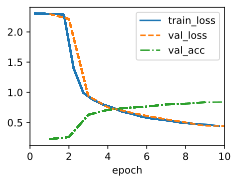

In [4]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

## 讨论

AlexNet的结构与LeNet非常相似，但进行了一些关键改进，这些改进既提高了准确性（如dropout）也简化了训练过程（如ReLU）。同样引人注目的是深度学习工具方面取得的进步。2012年需要几个月才能完成的工作现在使用任何现代框架只需十几行代码即可实现。

回顾架构，我们发现AlexNet在效率方面有一个明显的弱点：最后两个隐藏层分别需要大小为$6400 \times 4096$和$4096 \times 4096$的矩阵。这对应于164 MB的内存和81 MFLOPs的计算量，对于较小的设备（如手机）来说，这两者都是不小的开销。这也是为什么AlexNet已经被我们在后续章节中将要讨论的更有效的架构所超越的原因之一。尽管如此，它仍然是从浅层网络到如今使用的深层网络的一个关键步骤。值得注意的是，即使参数数量远超我们的实验中的训练数据量（最后两层有超过4000万个参数，在一个包含6万张图片的数据集上训练），几乎没有任何过拟合现象：训练损失和验证损失在整个训练过程中几乎是相同的。这是由于现代深层网络设计中改进的正则化方法，如dropout。

尽管看起来AlexNet的实现只比LeNet多了几行代码，但学术界花了多年时间才接受这种概念上的变化并利用其出色的实验结果。这也部分是由于缺乏高效的计算工具。当时既没有DistBelief :cite:`Dean.Corrado.Monga.ea.2012`也没有Caffe :cite:`Jia.Shelhamer.Donahue.ea.2014`，而Theano :cite:`Bergstra.Breuleux.Bastien.ea.2010`仍然缺少许多特色功能。正是TensorFlow :cite:`Abadi.Barham.Chen.ea.2016`的出现极大地改变了这一局面。

## 练习

1. 根据上述讨论，分析AlexNet的计算特性。
    1. 分别计算卷积层和全连接层的内存占用。哪一种占据主导地位？
    1. 计算卷积层和全连接层的计算成本。
    1. 内存（读写带宽、延迟、大小）如何影响计算？它对训练和推理的影响有何不同？
1. 假设你是一名芯片设计师，需要权衡计算能力和内存带宽。例如，更快的芯片需要更多的电力，并可能需要更大的芯片面积。更高的内存带宽需要更多的引脚和控制逻辑，因此也需要更大的面积。你会如何优化？
1. 为什么工程师不再报告AlexNet的性能基准测试？
1. 尝试增加训练AlexNet时的epoch数。与LeNet相比，结果有何不同？为什么？
1. AlexNet对于Fashion-MNIST数据集来说可能过于复杂，特别是因为初始图像的分辨率较低。
    1. 尝试简化模型以加快训练速度，同时确保准确性不会显著下降。
    1. 设计一个可以直接处理$28 \times 28$图像的更好模型。
1. 修改批次大小，观察吞吐量（每秒处理的图像数量）、准确性和GPU内存的变化。
1. 在LeNet-5中应用dropout和ReLU。是否有改善？能否通过预处理来进一步改进，以利用图像中的不变性？
1. 你能使AlexNet过拟合吗？你需要移除或改变哪个特征来破坏训练？

[讨论](https://discuss.d2l.ai/t/76)